# Statistiques descriptives

Ici nous analyserons de façon globale les données textuelles que nous avons, en l'occurrence un corpus de X textes lemmatisés avec pour chaque lemme sa **fréquence** et son **type** associés.

Pour ce faire nous aurons besoin de :  
1.  `numpy` et `pandas` pour les opérations sur les données 
2.  `matplotlib.pyplot` pour la création de graphiques

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict

Pour conclure, les données sont dans l'ensemble plutôt cohérentes. Cependant, la forte dispersion des tailles des livres et de leur représentation dans les différents thèmes risquent de biaiser nos résultats. Même si l'on remarque que plus les livres semblent grands et pareillement plus les thèmes ont de représentants, plus les résultats semblent robustes (voir les lemmes du thème `"Société et Politique"` et les coefficients de diversité des livres les plus longs).  
Enfin, certains thèmes très représentés sont assez proches en termes de sens comme `"Décadence"`, `"Coutumes"` et `"Société et Politique"`, nous amenant à penser que les résultats de notre modèle de clustering sera sans doute peu concluant ou en tout cas, devront reposer sur d'autres thèmes.

Nous récupérons les **titres** des textes de `'Data/base_csv_final.csv'` et les **lemmes** (et leur fréquences et leurs types) de `'Data/info.parquet'`.

In [2]:
#Collecting data
texts=pd.read_csv('Data/base_csv_final.csv')
d_titles=texts['Title'].to_dict()
data=pd.read_parquet('Data/info.parquet', engine='pyarrow')

Ce programme sert à afficher le **nombre total de mots** dans chaque livre. Sans rentrer dans les détails :
1. Il récupère les fréquences de chaque lemmes dans la colonne `"Freq"`(en tenant compte du livre auquel ils appartiennt grâce à la colonne `"Id"`)
2. Il ne garde des titres que les 4 premiers mots pour des raisons d'affichage et trie les données dans l'ordre croissant
3. Les dernières lignes sont des commandes d'affichages propre à `matplotlib.pyplot` qui seront peu ou prou les mêmes pour chaque graphique


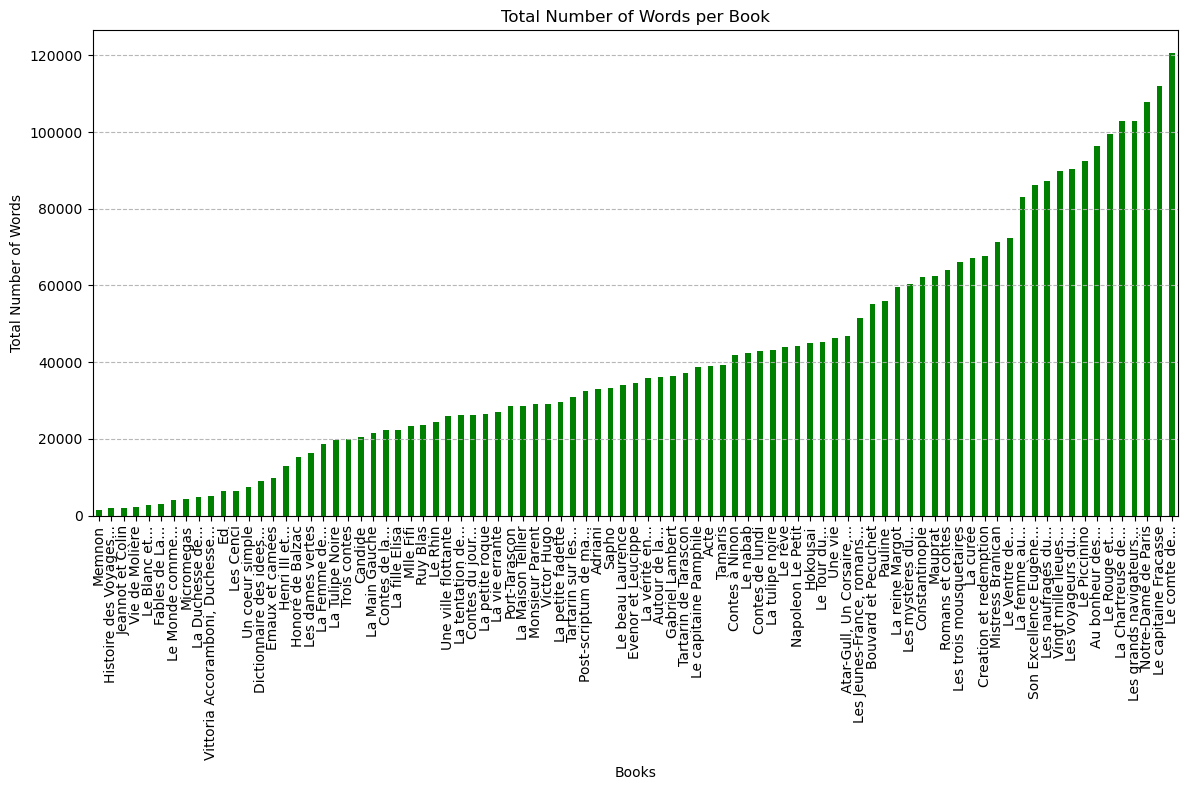

In [11]:
#Nombre total de mots par livre
w_total = data.groupby('Id')['Freq'].sum()

#Titre avec seulement les 4 premiers mots et nombre total de mots
d_total = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_total.items()
}

#Tri par valeurs croissantes
d_total_sorted = dict(sorted(d_total.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_total_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_total_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_total_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Total Number of Words per Book')
plt.xlabel('Books')
plt.ylabel('Total Number of Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_total_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

Nous avons ainsi une meilleure idée de la distribution des tailles des livres. *Memnon* est par exemple le plus court, Le comte de... (*Le comte de Moret*), le plus long.

Maintenant, regardons la distribution de la diversité des lemmes. Le programme est sensiblement le même qu'au-dessus, à cela près qu'il s'intéresse aux valeurs uniques de la colonne `Word` (Lemmes) plutôt que `Freq`.

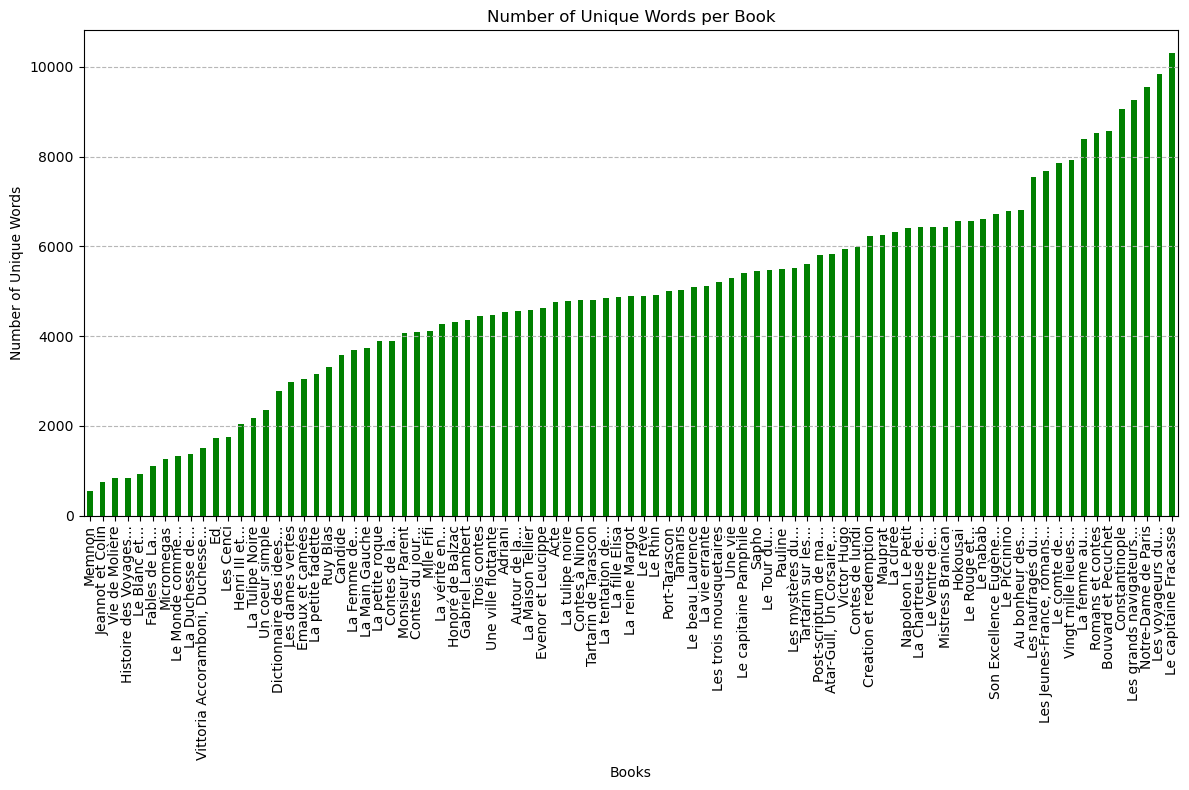

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#Nombre de mots différents par livre
w_unique = data.groupby('Id')['Word'].nunique()

#Titre avec seulement les 4 premiers mots et nombre de mots unique
d_unique = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_unique.items()
}

#Tri par valeurs croissantes
d_unique_sorted = dict(sorted(d_unique.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_unique_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_freq_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_unique_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Number of Unique Words per Book')
plt.xlabel('Books')
plt.ylabel('Number of Unique Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_unique_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()


*Le Memnon* reste le livre avec le plus petit nombres de lemmes et le bas de la distribution change peu du fait de questions de proportions. En revanche, le haut de la distribution change beaucoup. Par exemple, *Le capitaine Fracasse* a le plus grand nombre de lemmes différents et à l'inverse, malgré sa grande taille, *Le comte de Moret* se retrouve en 10ème position.

Pour véritablement avoir une idée de la diversité de chaque livre, on construit un **coefficient de diversité**. Il s'agit tout simplement du rapport entre le nombres de lemmes différents et le nombre total de lemmes. Ainsi, plus le coefficient est proche de 1, plus le vocabulaire employé est riche. Le fonctionnement du code combine les deux approches ci-dessus.

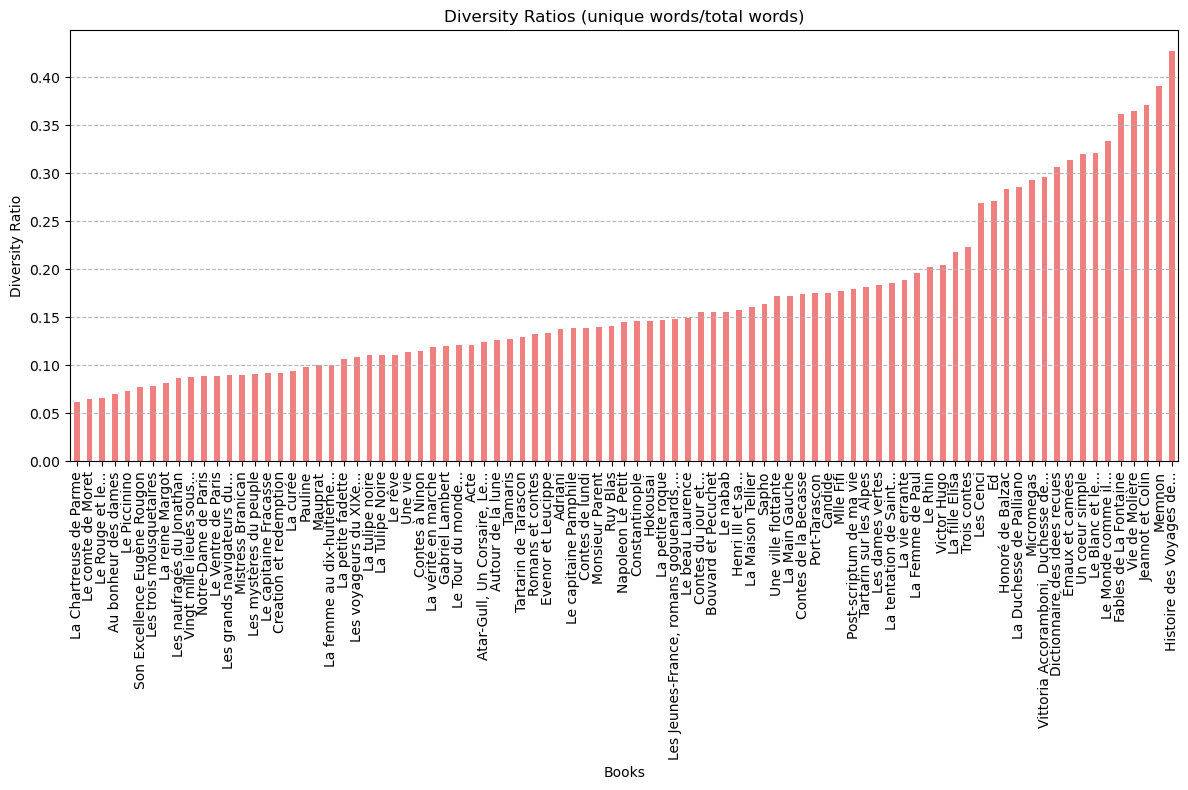

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Nombre de mots total par livre et nombre de mots différent
w_total= data.groupby('Id')['Freq'].sum()  
w_unique = data.groupby('Id')['Word'].nunique() 

# Coefficient de diversité (nombre de mots différents/nombre de mots total)
diversity_ratio = (w_unique / w_total).sort_values()


#Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
l_books =  [' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else '') for book_id in diversity_ratio.index]


#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(diversity_ratio)) * 2
#Tracé des barres
plt.bar(x_positions, diversity_ratio, color='lightcoral', width=0.9)
#Titre et labels des axes
plt.title('Diversity Ratios (unique words/total words)')
plt.xlabel('Books')
plt.ylabel('Diversity Ratio')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, l_books, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

On observe, sans surprise, que les plus petits livres ont une diversité bien plus grande. Par exemple, la nouvelle *Un coeur simple* est la 8ème la plus riche en termes de vocabulaire et l'énorme roman qu'est *La Chartreuse de Parme* en dernière position.   
Notons qu'*Un coeur simple* est au-dessus de *Trois contes* de 8 places, alors même que cette nouvelle fait partie des trois contes. Même si les deux autres contes peuvent influer sur la diversité du vocabulaire, cela nous conforte dans l'idée que la taille du livre est une variable très importante dans l'analyse de nos données.  
Cependant, si l'on regarde le bas de la distribution, on retrouve certains des résultats au-dessus (par exemple la place cohérente de *Le capitaine Fracasse*, ayant beaucoup de lemmes et très diversifiés, par rapport à *Le comte de Moret*).
De même, *Ruy Blas* a beau être une pièce de théâtre, son faible nombre de lemmes différents (voir au-dessus) fait que son coefficient de diversité est proche de la médiane. Ainsi, même un texte plus court peut avoir un coefficient moins élevé, laissant à penser que l'indicateur est biaisé mais tout de même pertinent.

Le programme suivant compte le nombre moyen de chaque type de mots, utilisé dans chaque livre. Tout d'abord, il agrège les fréquences par type et par livre puis il en calcule la moyenne grâce à `.mean()`.

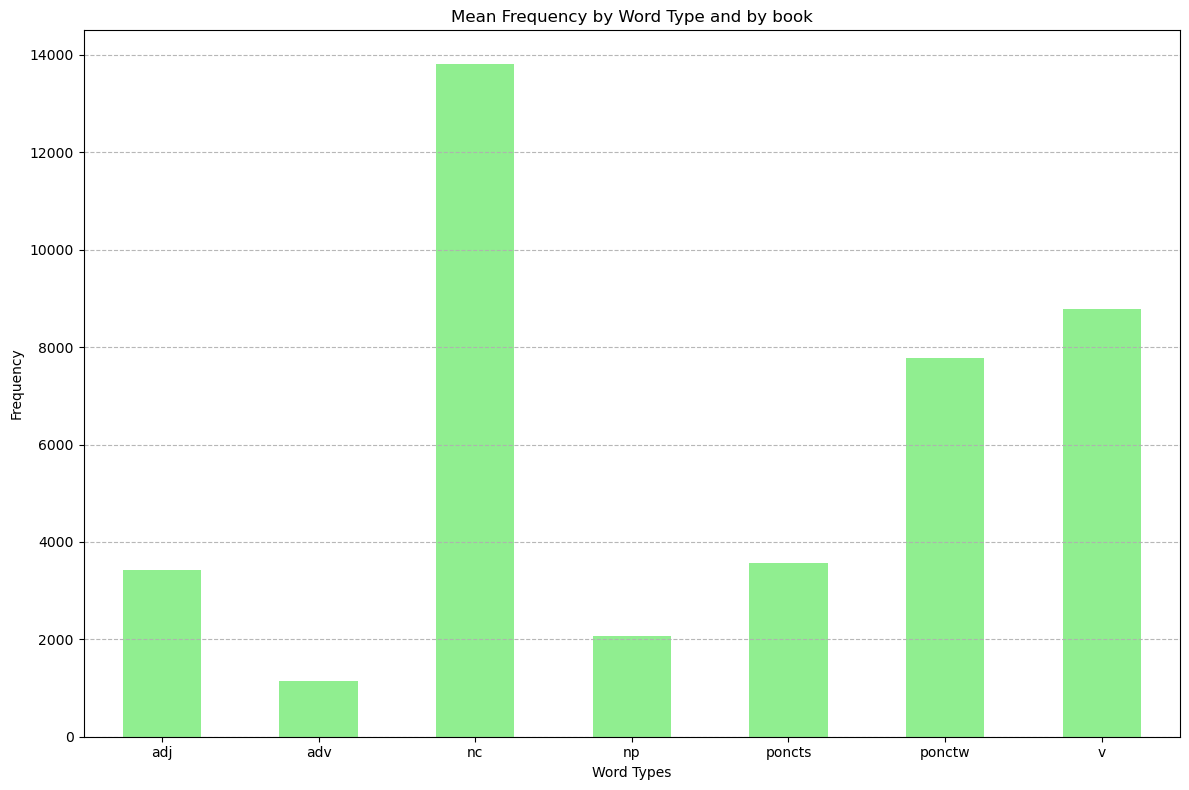

In [42]:
#Somme des fréquences par livre et type
df_stats = data.groupby(['Id', 'Type'])['Freq'].sum().reset_index()
#Récupération des moyenns par type
df_stats = df_stats.groupby('Type')['Freq'].mean()

#Liste des principeaux types de mots
l_included = ['nc', 'v', 'adj', 'np', 'adv', 'ponctw','poncts']

#Filtrage pour ne garder que les types voulus
df_filtered = df_stats[df_stats.index.isin(l_included)]

# Step 3: Plot the results
df_filtered.plot(kind='bar', figsize=(12, 8), color=['lightgreen'])

#Titre et labels des axes
plt.title('Mean Frequency by Word Type and by book')
plt.xlabel('Word Types')
plt.ylabel('Frequency')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Abscisses mises à l'horizontal
plt.xticks(rotation=0)
#Affichage
plt.tight_layout()
plt.show()

La distribution des types est très cohérentes. Les noms communs, les marques de ponctuations (`"poncts"` et `"ponctw"`) et les verbes sont omniprésents. Les adjectifs semblent légèrement rares par rapport à ce à quoi l'on pourrait s'attendre. en revanche, les adverbes sont, de façon très logique peu présents.

Pour avoir une idée du contenu global des livres du corpus, nous allons tracer un nuage des lemmes les plus utilisés. Pour ce faire, nous utilisons le package `wordcloud` qui sert à créer des nuages de points.

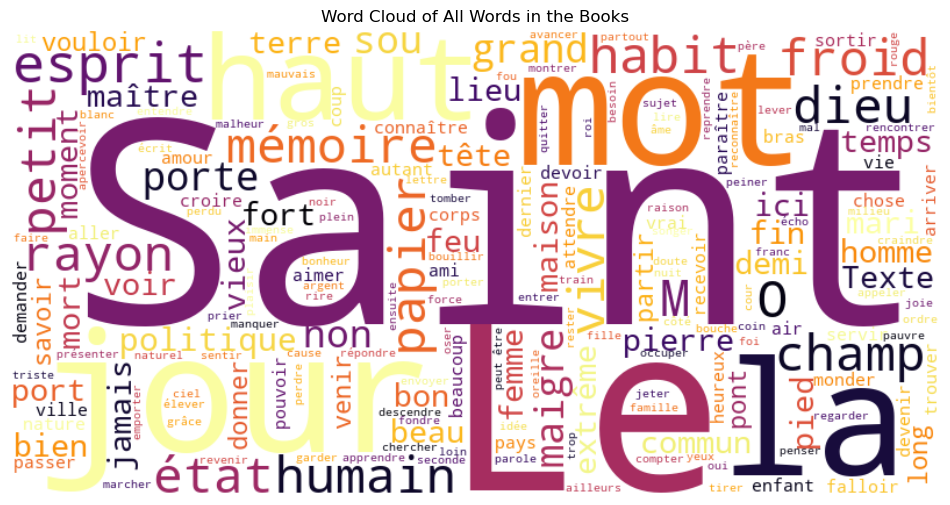

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Rassemble tous les mots dans data 
all_words = " ".join(data[data['Type'].isin(['nc', 'v', 'adj', 'np', 'adv'])]['Word'].astype(str))

#Création du nuage à partir des mots de data
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(all_words)

#Taille graph
plt.figure(figsize=(12, 8))
#Dessin du nuage
plt.imshow(wordcloud, interpolation='bilinear')
#Retrait des axes
plt.axis('off')
#Titre
plt.title('Word Cloud of All Words in the Books')
#Affichage
plt.show()


Les mots les plus présents dans le corpus sont des mots assez généraux, ce qui est assez rassurant. Des déterminants comme "le" ou "la", des noms communs renvoyant à des choses du quotidien comme "jour" ou "habit" ou encore des verbes communs comme "aller" ou "faire". La présence du mot "saint" comme le plus récurrent est la seule données vraiment surprenante de ce nuage de point. L'absence du verbe "être" et "avoir" aurait pu l'être aussi mais elle s'explique par leur catégorisation comme auxiliaire.

Regardons maintenant la distribution des livres par thème. Le programme fonctionne comme suit : 
1. Il réorganise la colonne `"Themes"` en dupliquant chaque ligne contenant plusieurs thèmes (pour n'avoir plus qu'un thème par ligne)
2. Il recense le nombre de livres pour chaque thème
3. Affichage de l'histogramme grâce à `matplotlib.pyplot`

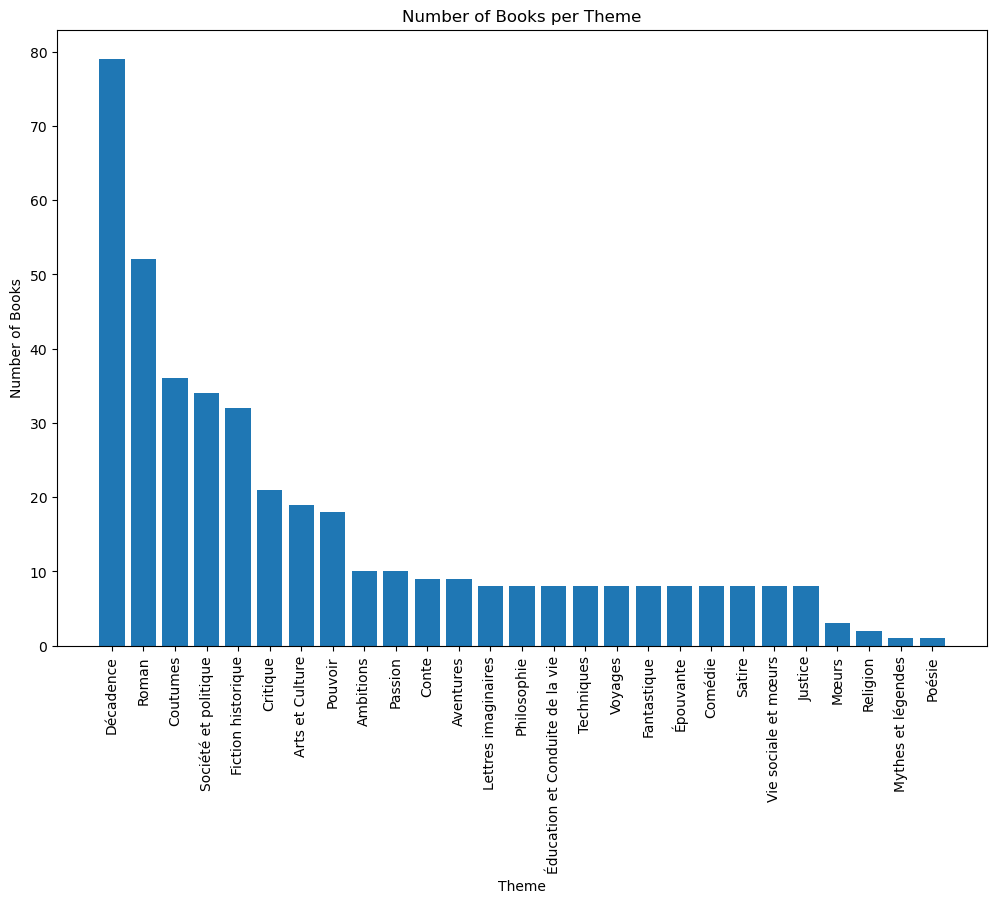

In [13]:
#Séparation des thèmes en listes si les thèmes sont sous forme d'un unique string
texts['Themes'] = texts['Themes'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

#Création de lignes spullémentaires pour qu'il n'y ait plus que un thème par ligne
texts_exploded = texts.explode("Themes")

#Nombre de livres par thème dans un dataframe
df_counts = texts_exploded['Themes'].value_counts().reset_index()
df_counts.columns = ['Theme', 'Number of Books']


#Taille graph
plt.figure(figsize=(12, 8))
#Tracé des barres
plt.bar(df_counts['Theme'], df_counts['Number of Books'])
#Titre et labels des axes
plt.xlabel('Theme')
plt.ylabel('Number of Books')
plt.title('Number of Books per Theme')
#Abscisses à l'horizontal
plt.xticks(rotation=90, fontsize=10)
#Affichage
plt.show()

Notre corpus contient des thèmes avec de nombreux représentants mais pour l'essentiel, chaque thème est présent dans moins d'une dizaine de livres. Le thème de la décadence et du roman sont fortement représentés. Si le second peut s'expliquer par son caractère général et par le fait qu'il s'agit d'un genre plus développé que la poésie par exemple, le premier est plus surprenant. Sans doute le choix de la période (correspondant approximativement à 1600-1900) et surtout le fait que la littérature du XIXème siècle semble surreprésentée peut en expliquer une partie. 

Après le nombre de livres par thèmes, regardons la répartition des lemmes par thèmes. Le code ci-dessous fonctionne de la sorte : 
1. Il parcourt et recense les fréquences de chaque lemmes en fonction du thème et du livre
2. A partir de ces fréquences il retient les 20 mots les plus utilisés dans tout le corpus et les mots qui apparaissent dans plus de 3 livres différents ayant les mêmes thèmes
3. Il recense ensuite les fréquences des lemmes qui ne sont ni très utilisés, ni présents dans plusieurs livres aux mêmes thèmes
4. Il affiche le graphique de quelques thèmes


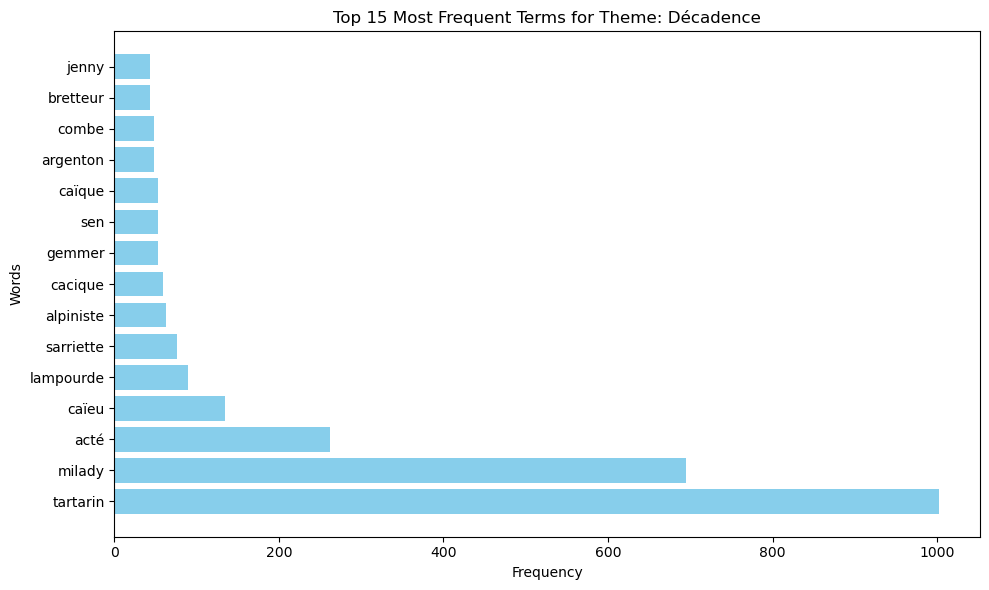

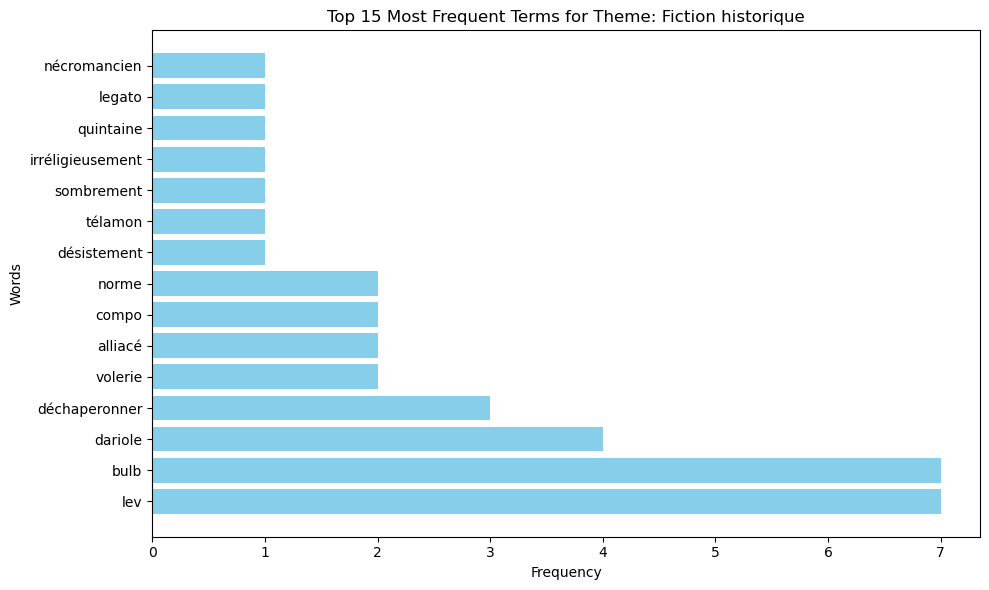

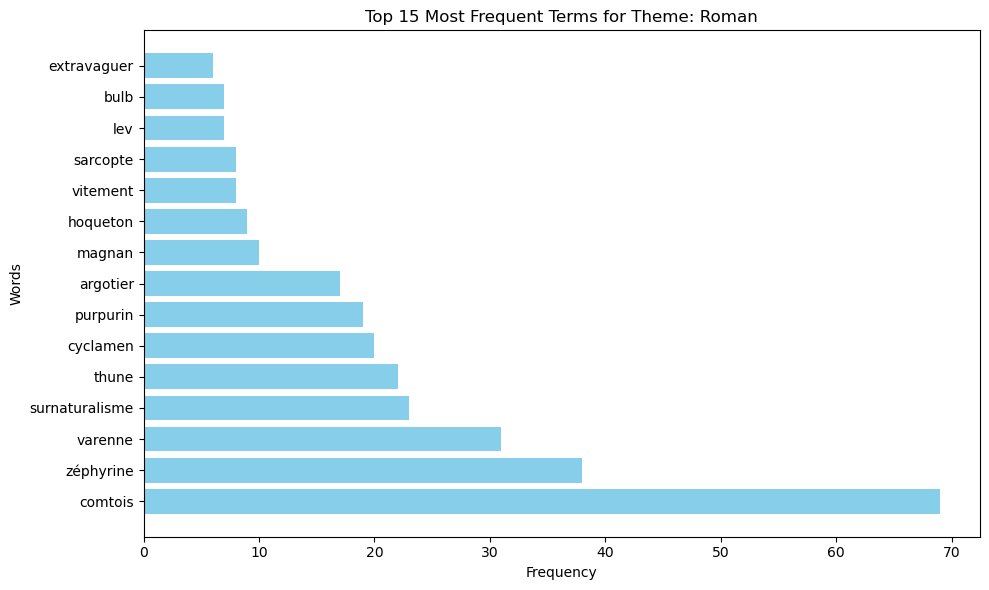

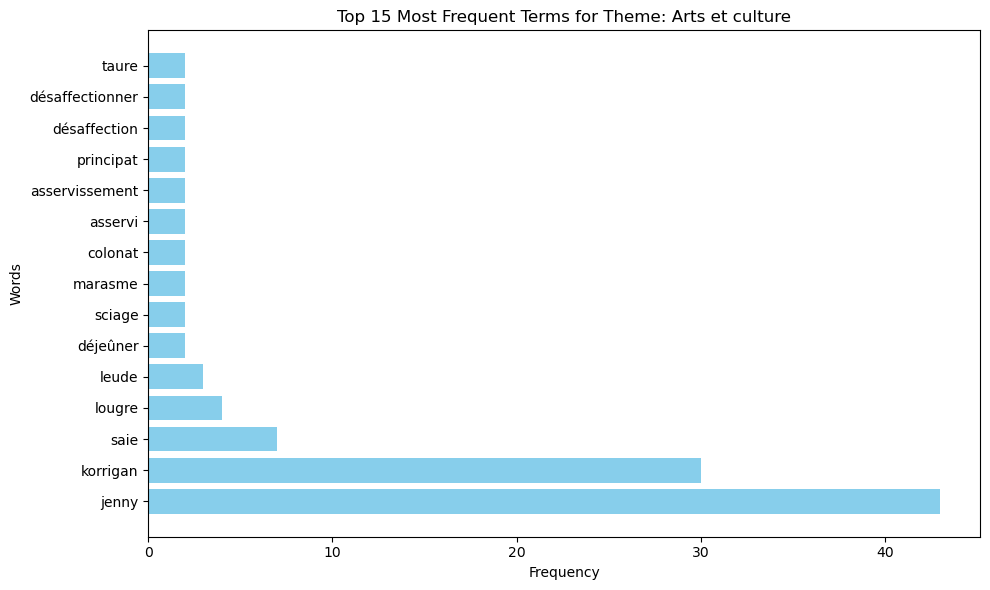

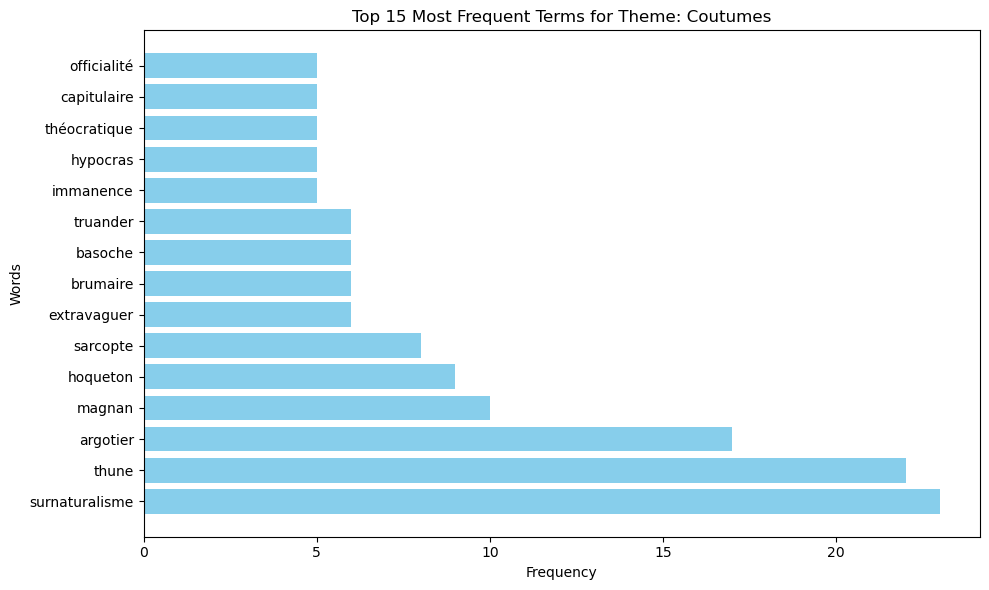

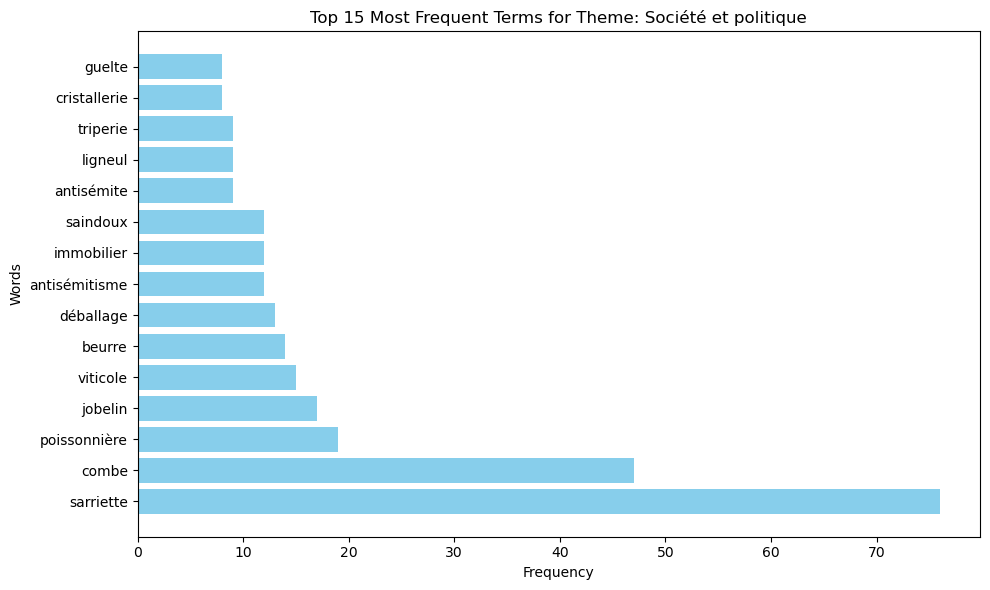

In [ ]:
theme_word_freq = defaultdict(lambda: defaultdict(int))

exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

total_word_freq = defaultdict(int)

word_theme_count = defaultdict(int)

#Comptage des occurences de chaque mot et de chaque mot par thème
for idx, row in texts.iterrows():
 
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    book_id = idx 
    
    book_df = data[data['Id'] == book_id]
    
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:
            total_word_freq[word] += freq
            
            for theme in themes:
                word_theme_count[word] += 1

#Listes des lemmes à exclure (les 20 plus présents et ceux présents dans plus de 2 thèmes)
top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

#Récupération des fréquences des lemmes qui ne sont pas dans les listes au-dessus
for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    book_id = idx  

    book_df = data[data['Id'] == book_id]
   
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types): 
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:  
                freq = float(freq)  
                theme_word_freq[theme.strip().lower()][word] += freq  

#Thèmes à afficher
themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"] 

for theme, word_freqs in theme_word_freq.items():
    
    if theme in [t.lower() for t in themes_to_plot]:
        
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        
        #Paramètres d'affichage
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


Comme nous avons imposé que les lemmes dans chaque thèmes ne soient pas très utilisés (pour garantir qu'ils soient plus représentatifs de chaque thèmes), certains lemmes ont peu d'occurrences. Le thème `"Fiction historique"` en particulier culmine à 7 occurrences.  
Cependant, grâce à cette sélection, les mots présents sont assez représentatifs de leur thème pour l'essentiel, du moins pour les thèmes fortement représentés. Le thème `"Société et politique"` par exemple, comprend des mots comme "antisémitisme" ou "immobilier".  
Si l'on s'intéresse maintenant au thème `"Arts et culture"`, aucun mot ne semble vraiment renvoyer à ce thème et les deux mots les plus présents en termes de fréquence le sont sans doute du fait d'un ou deux livres où ils sont répétés.
Là encore, la taille de l'échantillon importe beaucoup, même s'il ne s'agit plus de la taille des livres mais des thèmes.

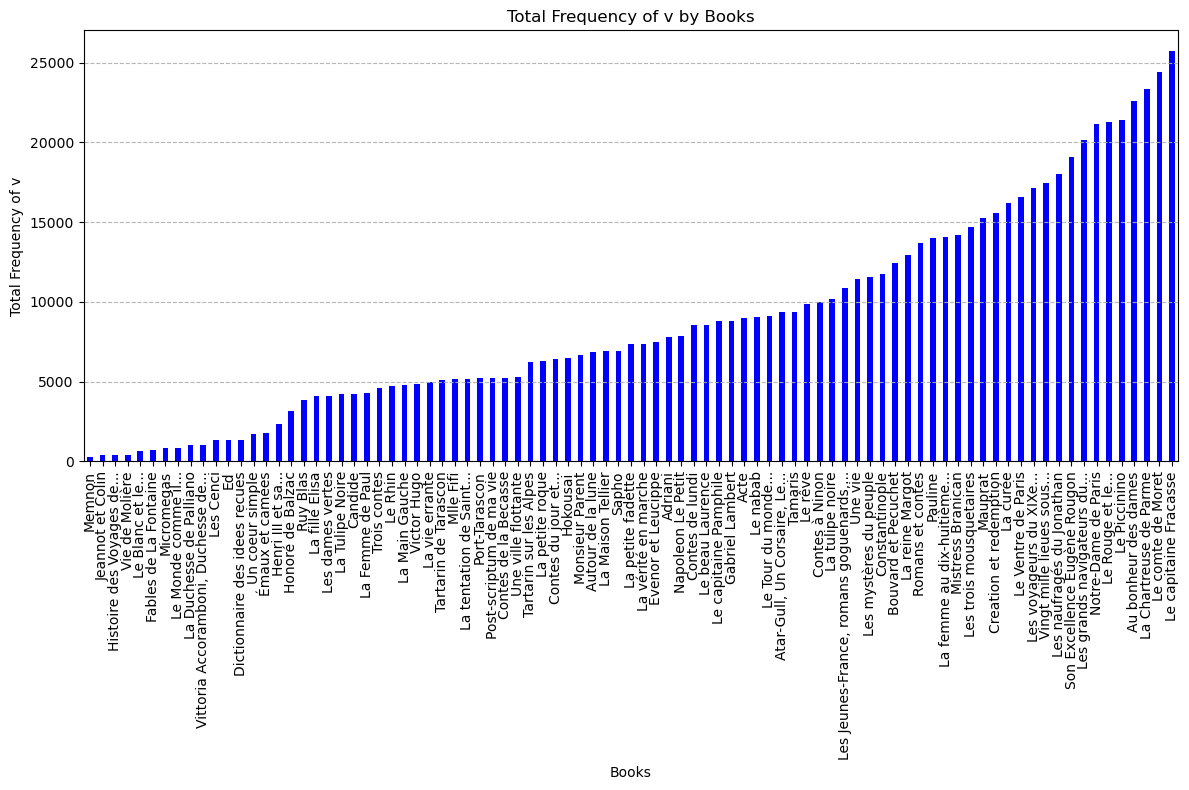

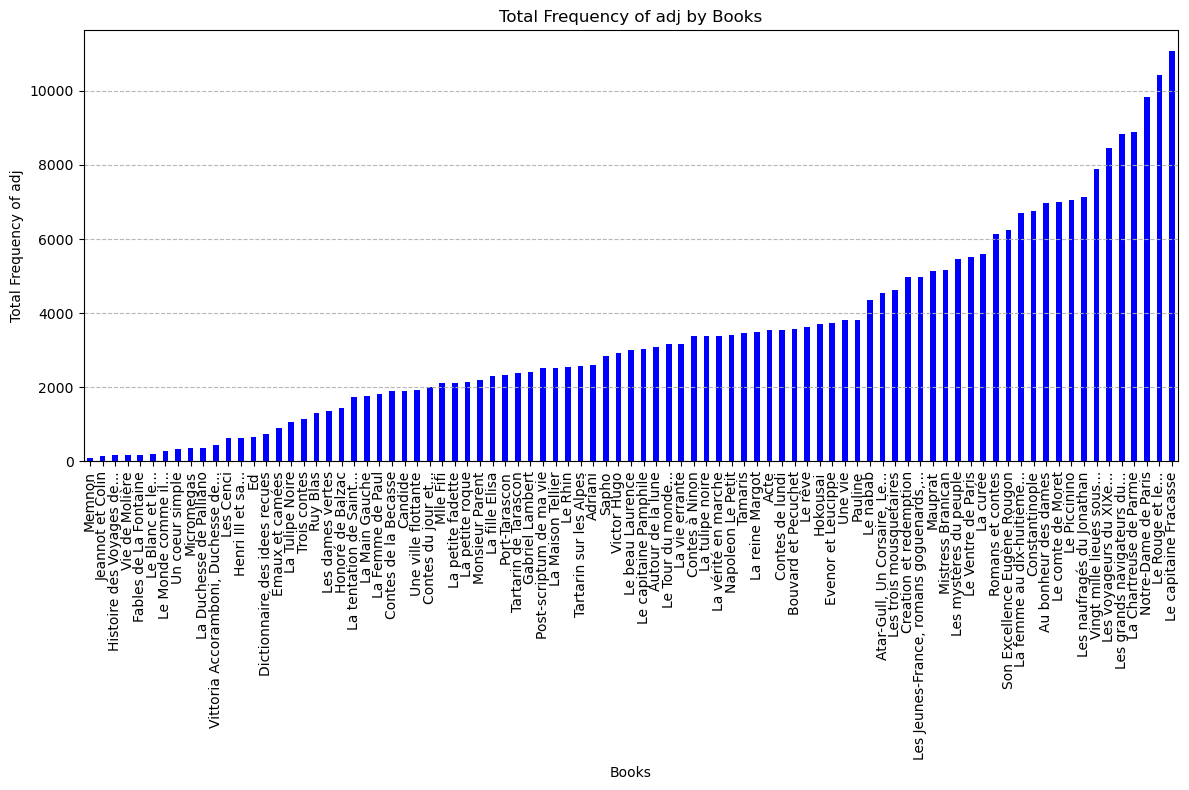

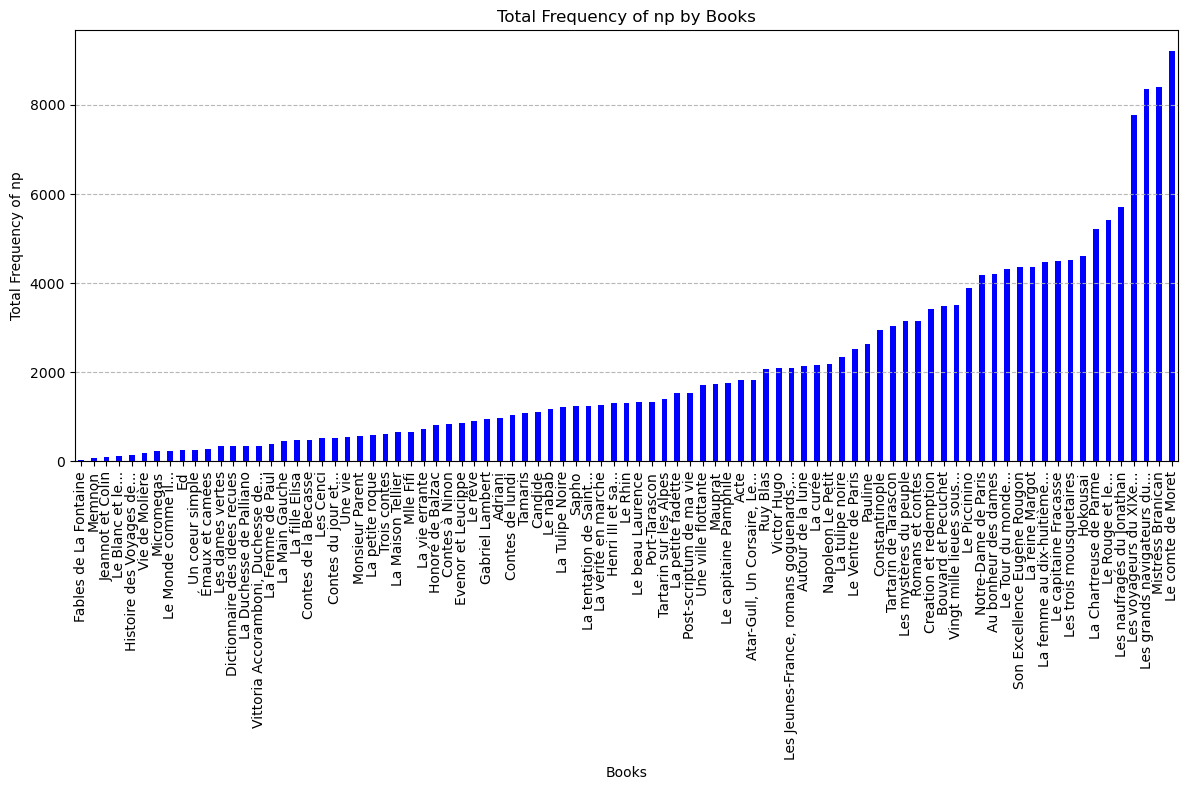

In [5]:
for w_type in ['v','adj','np'] :

    #Tri de data en fonction du type
    df_sorted = data[data['Type'] == w_type]

    #Somme des fréquences des mots de ce type par livre
    df_sum= df_sorted.groupby('Id')['Freq'].sum()
    d_freq = {
        #Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
        ' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else ''): freq
        for book_id, freq in df_sum.items()
    }
    #Tri pour avoir des valeurs croissantes
    d_freq_sorted = dict(sorted(d_freq.items(), key=lambda item: item[1]))
    #Taille du graph
    plt.figure(figsize=(12, 8))
    #Répartition des positions pour l'axe des abscisses
    x_positions = np.arange(len(d_freq_sorted))*2
    #Tracé des barres
    plt.bar(x_positions, list(d_freq_sorted.values()), color='blue', width=0.9)
    #Titre et labels des axes
    plt.title(f'Total Frequency of {w_type} by Books')
    plt.xlabel('Books')
    plt.ylabel(f'Total Frequency of {w_type}')
    #Ajout d'une grille honrizontale
    plt.grid(True, axis='y', linestyle='--', alpha=0.9)
    #Limites de l'axe des abscisses
    plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
    #Paramètres des abscisses 
    plt.xticks(x_positions, list(d_freq_sorted.keys()), rotation=90, ha='center', fontsize=10) 
    #Affichage (tight_layout pour un rendu plus propre)
    plt.tight_layout()
    plt.show()
